In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import dates as mdates
import csv
import pandas as pd
import scipy.io as scio
import warnings
warnings.filterwarnings('ignore')
from pylab import *

# Utils

In [35]:
# the following part creates a new class which is similar 
# to dictionary but can store dictionary data type in it. 
class Vividict(dict):
    def __missing__(self, key):
        value = self[key] = type(self)()
        return value
    
def Gopro_videoOrder(path):
    # this function is trying to sort the order of GoPro video 
    # because the default order by name in the computer
    # is not the real temporal order of the videos

    # input: path, the path of unprocessed images folder of GoPro videos
    video_list = os.listdir(path)
    for i in range(len(video_list)-1):
        min_index = i
        for j in range(i, len(video_list)-1):
            if int(video_list[min_index][6:8]) > int(video_list[j+1][6:8]):
                min_index = j + 1
            elif int(video_list[min_index][6:8]) == int(video_list[j+1][6:8]):
                if int(video_list[min_index][2:4]) > int(video_list[j+1][2:4]):
                    min_index = j + 1
        swap_video = video_list[min_index]
        video_list[min_index] = video_list[i]
        video_list[i] = swap_video
    return video_list

def Gopro_videoCombine(video_list, path_unprocessed, path_WFcsv):
    # this function is trying to include all the whitecap fraction
    # of the GoPro videos taken in one day in a variable with 
    # dictionary data type. The key of this dictionary is the name of the video. 
    # the value is also a dictionary data type variable. The value
    # contains the whitecap fraction and the image order respectively. 
    # The reason for this function is to compare the data with manual filtering for sun
    # glints with the data unprocessed so that we can let all images in their real 
    # time slot without mismatching. No need for deep learning processed data since 
    # no image was deleted manually.

    # input: video_list, the list of video name which has been sorted by Gopro_videoOrder function
    #        path_unprocessed, the path of unprocessed images folder of GoPro videos
    #        paht_WFcsv, the path of the folder including the whitecap fraction .csv data
    video_image = Vividict()
    for i in range(0, len(video_list)):
        image_list = os.listdir(f"{path_unprocessed}/{video_list[i]}")
        for img in image_list[:]:
            if img[:2] == '._':
                image_list.remove(img)
        image_list.sort(key=lambda x:int(x[14:-4]))
        for j in range(0, len(image_list)):
            video_image[video_list[i]][image_list[j]] = np.nan
            # the reason for that is because some images in a video has been deleted because of the glints. 

            data_wf = []
            path = f"{path_WFcsv}/{video_list[i]}/"
            if video_list[i] not in os.listdir(path_WFcsv):
                continue
            with open(path + video_list[i][:8] + "_ATS_wf.csv") as csvfile: 
                csv_reader = csv.reader(csvfile, delimiter = ' ', quotechar = ' ')
                for row in csv_reader:
                    data_wf.extend(float(n) for n in row)
            if j < len(data_wf):
                video_image[video_list[i]][image_list[j]] = data_wf[j]
    return video_image


def SecTo20min(video_list, video_image):
    # this function transfer the whitecap fraction data from second to 20 minutes
    # this function go with Gopro_videoCombine function
    wf_second = []
    wf_20min = []
    for n in range(len(video_list)):
        wf_second.extend(video_image[video_list[n]].values())
    for i in range(len(wf_second) // 1200):
        realnum = 1200
        for j in range(1200):
            if np.isnan(wf_second[i*1200+j]):
                realnum = realnum - 1
                wf_second[i*1200+j] = 0
        if realnum == 0:
            wf_20min.append(0)
        else:
            wf_20min.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
    return wf_20min

def SecTo20min_active(data_path, video_list):
    """This function is to transfer the whitecap fraction data from second to 20 minutes.
    Differet from SecTo20min, this function used for the data without manual processing.

    Args:
        data_path (str): path of the folder including the whitecap fraction .csv data
        video_list (list): list of video name in the order of time

    Returns:
        list: 20 min averaged total/active whitecap fraction
    """
    active_data = []
    for fname in video_list:
        video_data = pd.read_csv(os.path.join(data_path, fname))
        active_data.extend(np.ndarray.tolist(video_data['active_whitecaps_fraction'].values))
    wf_second = active_data
    wf_20min_active = []
    for i in range(0, len(wf_second) // 1200):
        realnum = 1200
        for j in range(0, 1200):
            if np.isnan(wf_second[i*1200+j]):
                realnum = realnum - 1
                wf_second[i*1200+j] = 0
        if realnum == 0:
            wf_20min_active.append(0)
        else:
            wf_20min_active.append(sum(wf_second[i*1200:(i*1200+1199)])/realnum)
    return wf_20min_active

# Data Loading

In [36]:
# data path
path_4l = "D:/GoPro_1Hz_Unet_output/2020_3_4_GoPro/image_left"
path_5l = "D:/GoPro_1Hz_Unet_output/2020_3_5_GoPro/image_left"
path_6l = "D:/GoPro_1Hz_Unet_output/2020_3_6_GoPro/image_left"
path_7l = "D:/GoPro_1Hz_Unet_output/2020_3_7_GoPro/image_left"

# sort the order of GoPro videos according to the time
video_list_4l = Gopro_videoOrder(path_4l)
video_list_5l = Gopro_videoOrder(path_5l)
video_list_6l = Gopro_videoOrder(path_6l)
video_list_7l = Gopro_videoOrder(path_7l)

wf_20min_active_4l = SecTo20min_active(path_4l, video_list_4l)
wf_20min_active_5l = SecTo20min_active(path_5l, video_list_5l)
wf_20min_active_6l = SecTo20min_active(path_6l, video_list_6l)
wf_20min_active_7l = SecTo20min_active(path_7l, video_list_7l)

print(f"2020.3.4 points number: {len(wf_20min_active_4l)}; time: {len(wf_20min_active_4l)*20} min ({len(wf_20min_active_4l)*20/60} h)")
print(f"2020.3.5 points number: {len(wf_20min_active_5l)}; time: {len(wf_20min_active_5l)*20} min ({len(wf_20min_active_5l)*20/60} h)")
print(f"2020.3.6 points number: {len(wf_20min_active_6l)}; time: {len(wf_20min_active_6l)*20} min ({len(wf_20min_active_6l)*20/60} h)")
print(f"2020.3.7 points number: {len(wf_20min_active_7l)}; time: {len(wf_20min_active_7l)*20} min ({len(wf_20min_active_7l)*20/60} h)")

2020.3.4 points number: 11; time: 220 min (3.6666666666666665 h)
2020.3.5 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.6 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.7 points number: 23; time: 460 min (7.666666666666667 h)


In [48]:
# data path
path_4r = "D:/GoPro_1Hz_Unet_output/2020_3_4_GoPro/image_right"
path_5r = "D:/GoPro_1Hz_Unet_output/2020_3_5_GoPro/image_right"
path_6r = "D:/GoPro_1Hz_Unet_output/2020_3_6_GoPro/image_right"
path_7r = "D:/GoPro_1Hz_Unet_output/2020_3_7_GoPro/image_right"

# sort the order of GoPro videos according to the time
video_list_4r = Gopro_videoOrder(path_4r)
video_list_5r = Gopro_videoOrder(path_5r)
video_list_6r = Gopro_videoOrder(path_6r)
video_list_7r = Gopro_videoOrder(path_7r)

wf_20min_active_4r = SecTo20min_active(path_4r, video_list_4r)
wf_20min_active_5r = SecTo20min_active(path_5r, video_list_5r)
wf_20min_active_6r = SecTo20min_active(path_6r, video_list_6r)
wf_20min_active_7r = SecTo20min_active(path_7r, video_list_7r)

print(f"2020.3.4 points number: {len(wf_20min_active_4r)}; time: {len(wf_20min_active_4r)*20} min ({len(wf_20min_active_4r)*20/60} h)")
print(f"2020.3.5 points number: {len(wf_20min_active_5r)}; time: {len(wf_20min_active_5r)*20} min ({len(wf_20min_active_5r)*20/60} h)")
print(f"2020.3.6 points number: {len(wf_20min_active_6r)}; time: {len(wf_20min_active_6r)*20} min ({len(wf_20min_active_6r)*20/60} h)")
print(f"2020.3.7 points number: {len(wf_20min_active_7r)}; time: {len(wf_20min_active_7r)*20} min ({len(wf_20min_active_7r)*20/60} h)")

2020.3.4 points number: 10; time: 200 min (3.3333333333333335 h)
2020.3.5 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.6 points number: 20; time: 400 min (6.666666666666667 h)
2020.3.7 points number: 21; time: 420 min (7.0 h)


In [43]:
# read in wind data
wind_time_20min = pd.read_csv('C:/Users/kevinyang/OneDrive - Texas A&M University/Buoy Data near Cruise/WindsByScott_time_20min.csv',
                        sep=' ',names=['time'],header=None)
data_20min = pd.read_csv('C:/Users/kevinyang/OneDrive - Texas A&M University/Buoy Data near Cruise/WindsByScott_20min.csv',
                   sep=' ',names=['ucm', 'vcm', 'wcm'],header=None)
wind_time_20min.apply(pd.to_datetime, axis==0)
wind_data_20min = pd.concat([wind_time_20min, data_20min], axis=1)

wind_data_20min['time'] = pd.to_datetime(wind_data_20min['time'])
wind_data_20min = wind_data_20min.set_index('time')

print(f"2020.3.4 points number: {len(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm'])}; time: {len(wf_20min_active_4l)*20} min ({len(wf_20min_active_4l)*20/60} h)")
print(f"2020.3.5 points number: {len(wind_data_20min['2020-03-05 8:00':'2020-03-05 17:00']['ucm'])}; time: {len(wf_20min_active_5l)*20} min ({len(wf_20min_active_5l)*20/60} h)")
print(f"2020.3.6 points number: {len(wind_data_20min['2020-03-06 8:00':'2020-03-06 17:00']['ucm'])}; time: {len(wf_20min_active_6l)*20} min ({len(wf_20min_active_6l)*20/60} h)")
print(f"2020.3.7 points number: {len(wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00']['ucm'])}; time: {len(wf_20min_active_7l)*20} min ({len(wf_20min_active_7l)*20/60} h)")

2020.3.4 points number: 8; time: 220 min (3.6666666666666665 h)
2020.3.5 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.6 points number: 22; time: 440 min (7.333333333333333 h)
2020.3.7 points number: 20; time: 460 min (7.666666666666667 h)


In [44]:
wind_data_20min

,ucm,vcm,wcm
time,,,
2020-03-04 14:00:00,5.295121,-2.690385e-15,-2.601899e-15
2020-03-04 14:20:00,4.965126,-5.700150e-15,3.023510e-15
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15
...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15


In [51]:
# The data of whitecap fraction and wind speed are mismatched on 2020.3.4 and 2020.3.7. 
# And the data on 2020.3.4 14:00 to 2020.3.4 14:20 should be deleted because of the ship 
# introduced wave wakes.
# Trim to match the time
wind_data_20min = pd.concat([wind_data_20min['2020-03-04 14:40':'2020-03-04 18:00'],
                             wind_data_20min['2020-03-05 8:00':'2020-03-05 17:00'],
                             wind_data_20min['2020-03-06 8:00':'2020-03-06 17:00'],
                             wind_data_20min['2020-03-07 6:00':'2020-03-07 18:00']], axis=0,
                            join='outer')
wind_data_20min['W_a'] = wf_20min_active_4l[4:] + wf_20min_active_5l + wf_20min_active_6l[2:] + wf_20min_active_7l[:-3]
wind_data_20min['W_a_right'] = wf_20min_active_4r[3:] + wf_20min_active_5r + wf_20min_active_6r + wf_20min_active_7r[:-1]
# Drop the abnormal data
wind_data_20min = wind_data_20min.drop(index=wind_data_20min.loc[wind_data_20min['W_a'] > 0.004].index) 
wind_data_20min

,ucm,vcm,wcm,W_a,W_a_right
time,,,,,
2020-03-04 14:40:00,5.083742,7.031992e-15,1.887314e-15,0.000435,0.000428
2020-03-04 15:00:00,4.633596,1.021764e-15,-9.126198e-16,0.000397,0.000564
2020-03-04 15:20:00,3.908596,3.965608e-15,-4.319990e-15,0.000445,0.000452
2020-03-04 15:40:00,4.147173,-2.014332e-16,1.903666e-15,0.000398,0.000421
2020-03-04 16:00:00,4.237486,6.450598e-16,-3.558338e-16,0.000199,0.000228
...,...,...,...,...,...
2020-03-07 15:00:00,7.318852,-1.671458e-15,-4.876432e-16,0.001002,0.000394
2020-03-07 15:20:00,8.009256,1.307723e-14,-2.691040e-15,0.000604,0.000559
2020-03-07 15:40:00,7.743893,6.816534e-15,-3.173863e-15,0.000664,0.000538


In [52]:
# Average between left and right camera
w_a_3_4 = (wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']*100 
           + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a_right']*100)/2
w_a_3_5 = (wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a']*100 
           + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['W_a_right']*100)/2
w_a_3_6 = (wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a']*100 
           + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['W_a_right']*100)/2
w_a_3_7 = (wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']*100 
           + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a_right']*100)/2

# Plot

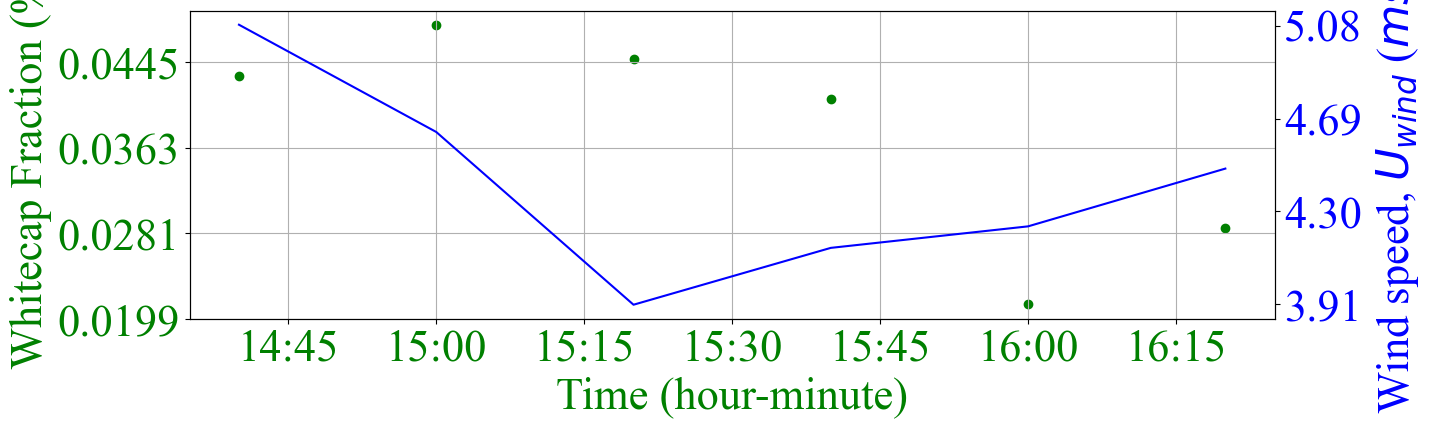

In [58]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

fig, ax = plt.subplots(figsize=(14, 4))

ax.scatter(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00'].index,w_a_3_4, color = 'green')

y_tick1 = np.linspace(round(min(100*wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']), 4), 
                      round(max(100*wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['W_a']), 4), 4)

plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction (%)", font, color = 'green')
plt.yticks(y_tick1, fontproperties = 'Times New Roman', size = 32, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 32, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

ax2 = ax.twinx()

ax2.plot(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
            + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2), color = 'blue')
y_tick2 = np.around(np.linspace(min(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']), 
                      max(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']), 4), decimals = 2)

plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{wind}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(y_tick2,fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

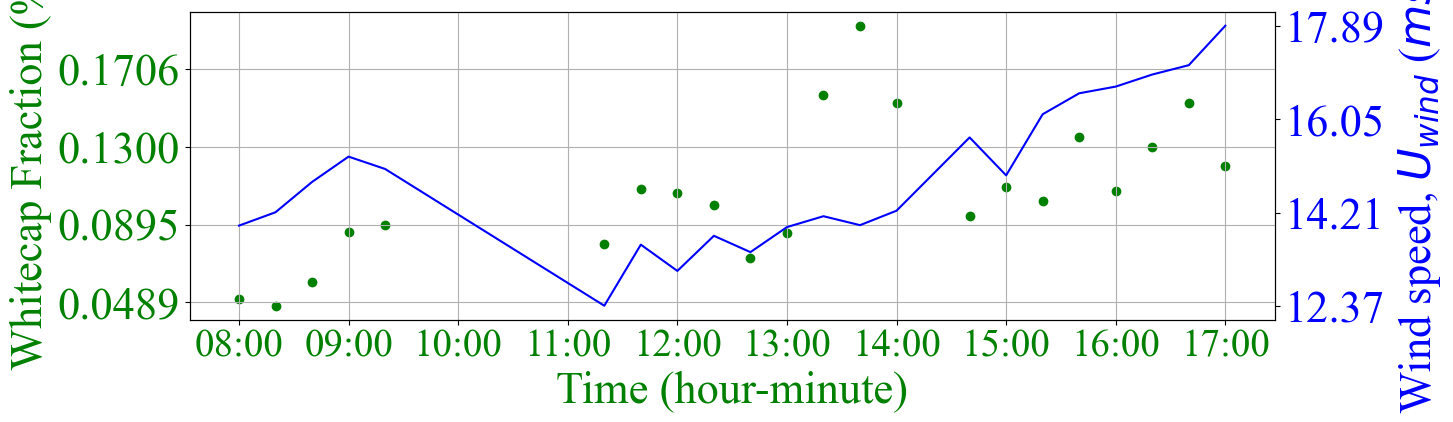

In [59]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

fig, ax = plt.subplots(figsize=(14, 4))


ax.scatter(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00'].index,w_a_3_5, color = 'green')

y_tick1 = np.linspace(round(100*min(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['W_a']), 4), 
                      round(100*max(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['W_a']), 4), 4)


plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction (%)", font, color = 'green')
plt.yticks(y_tick1, fontproperties = 'Times New Roman', size = 32, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

ax2 = ax.twinx()


ax2.plot(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2), color = 'blue')
y_tick2 = np.around(np.linspace(min(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['ucm']), 
                      max(wind_data_20min['2020-03-05 6:00':'2020-03-05 18:00']['ucm']), 4), decimals = 2)


plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{wind}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(y_tick2,fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

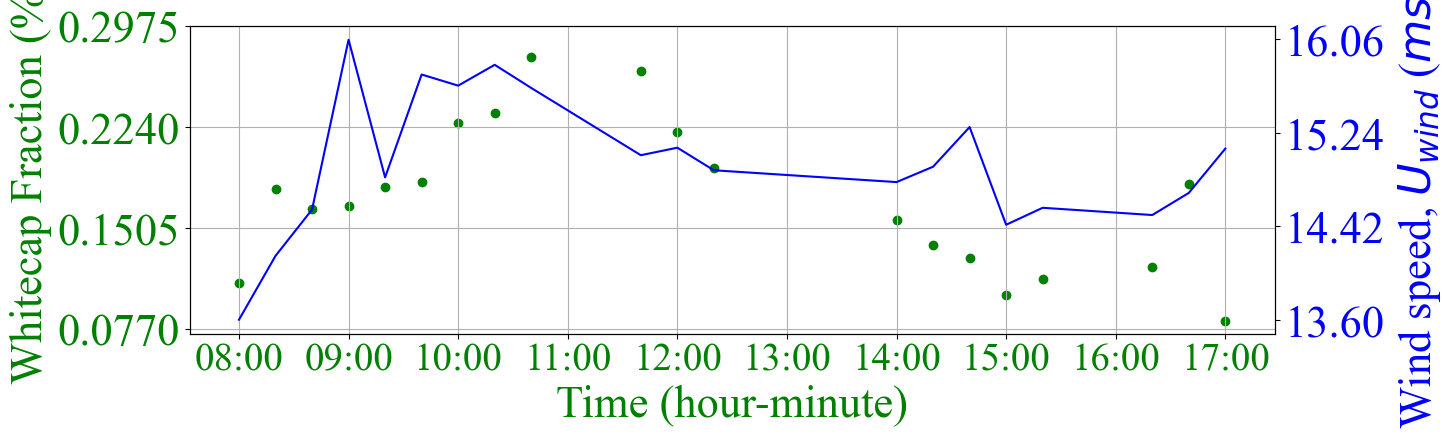

In [60]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

fig, ax = plt.subplots(figsize=(14, 4))


ax.scatter(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00'].index,w_a_3_6, color = 'green')
y_tick1 = np.linspace(round(100*min(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['W_a']), 4), 
                      round(100*max(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['W_a']), 4), 4)



plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction (%)", font, color = 'green')
plt.yticks(y_tick1, fontproperties = 'Times New Roman', size = 32, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

ax2 = ax.twinx()


ax2.plot(np.sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
            + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2), color = 'blue')
y_tick2 = np.around(np.linspace(min(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['ucm']), 
                      max(wind_data_20min['2020-03-06 6:00':'2020-03-06 18:00']['ucm']), 4), decimals = 2)


plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{wind}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(y_tick2, fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

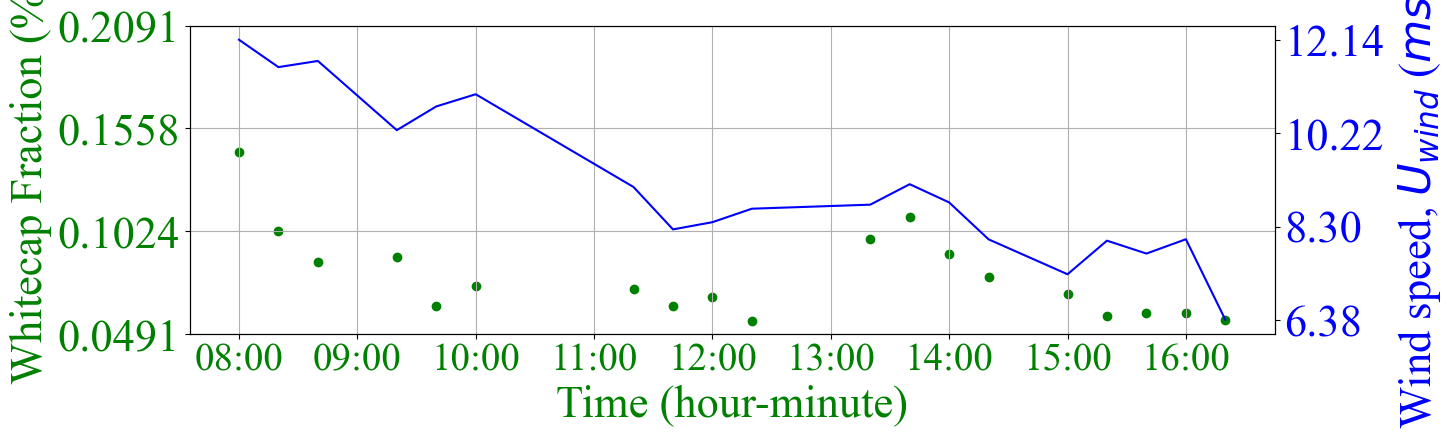

In [61]:
font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

fig, ax = plt.subplots(figsize=(14, 4))

ax.scatter(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00'].index,w_a_3_7, color = 'green')
y_tick1 = np.linspace(round(100*min(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']), 4), 
                      round(100*max(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['W_a']), 4), 4)


plt.grid()
plt.xlabel("Time (hour-minute)", font, color = 'green')
plt.ylabel("Whitecap Fraction (%)", font, color = 'green')
plt.yticks(y_tick1, fontproperties = 'Times New Roman', size = 32, color = 'green')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'green')
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

font = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 32,
}

ax2 = ax.twinx()


ax2.plot(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2), color = 'blue')
y_tick2 = np.around(np.linspace(min(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']), 
                      max(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']), 4), decimals = 2)

plt.xlabel("Time (hour-minute)", font, color = 'blue')
plt.ylabel("Wind speed, $U_{wind}$ ($m s^{-1}$)", font, color = 'blue')
plt.yticks(y_tick2, fontproperties = 'Times New Roman', size = 32, color = 'blue')
plt.xticks(fontproperties = 'Times New Roman', size = 28, color = 'blue')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Regression

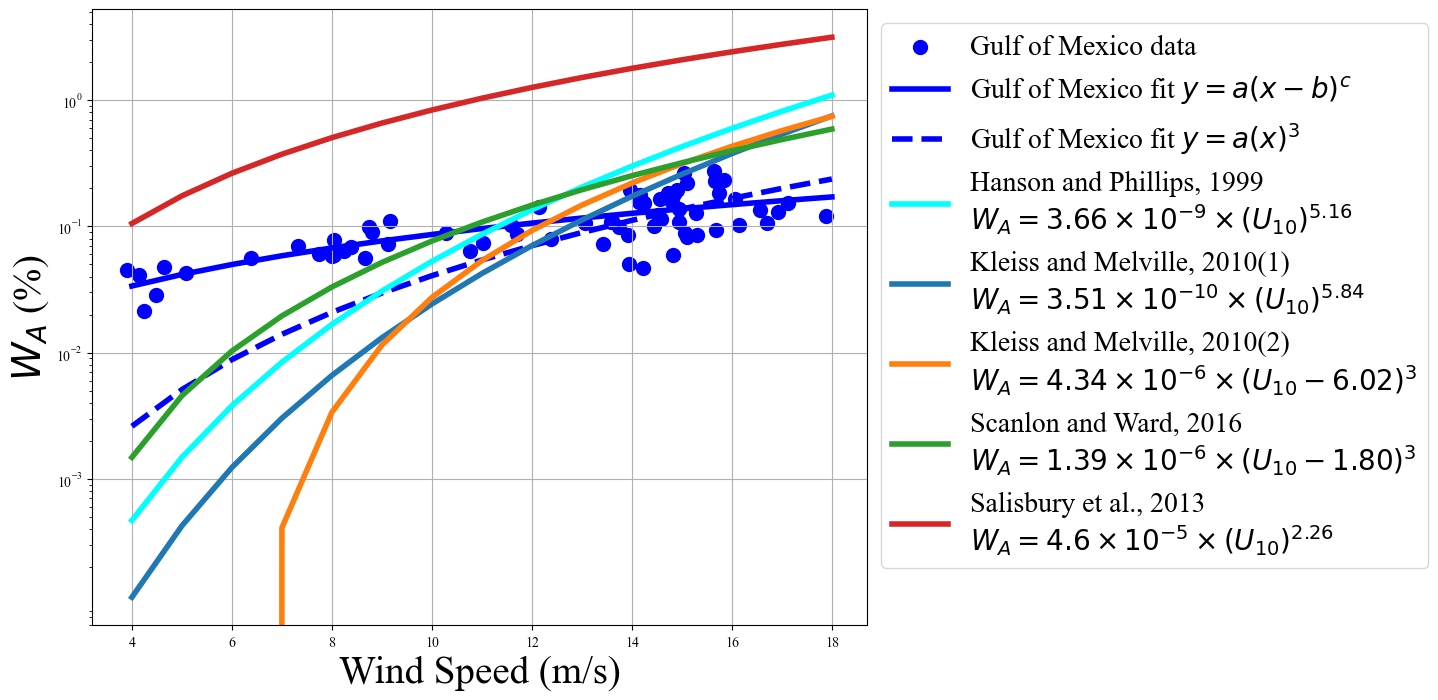

In [62]:
##### Take the average between the left and the right
fig, ax = plt.subplots()
fig.set_size_inches(10, 8)
ax.set_yscale("log")

yticks = [0.001, 0.01, 0.1, 1]
font_legend = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 28}


plt.scatter(np.sqrt(wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['ucm']**2 + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['vcm']**2
            + wind_data_20min['2020-03-04 14:00':'2020-03-04 18:00']['wcm']**2),
            w_a_3_4, color = 'blue', label='Gulf of Mexico data',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['ucm']**2 + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['vcm']**2
            + wind_data_20min['2020-03-05 8:00':'2020-03-05 18:00']['wcm']**2),
            w_a_3_5, color = 'blue',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['ucm']**2 + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['vcm']**2
            + wind_data_20min['2020-03-06 8:00':'2020-03-06 18:00']['wcm']**2),
            w_a_3_6, color = 'blue',s=100)
plt.scatter(np.sqrt(wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['ucm']**2 + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['vcm']**2
            + wind_data_20min['2020-03-07 8:00':'2020-03-07 18:00']['wcm']**2),
            w_a_3_7, color = 'blue',s=100)

from matplotlib.lines import lineStyles
from scipy.optimize import curve_fit
x = wind_data_20min['ucm'].values

y = (wind_data_20min['W_a'].values + wind_data_20min['W_a_right'].values)/2

# 这里的函数可以自定义任意形式。
def func1(x, a, b,c):
    return a*(x - b)**c

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt1, pcov = curve_fit(func1, x, y)
a = popt1[0] 
b = popt1[1]
c = popt1[2]
xtemp = np.arange(4,19,1)
yvals = func1(xtemp,a,b,c) #拟合y值

plot2 = plt.plot(xtemp, yvals*100, 'blue',label='Gulf of Mexico fit $y=a(x-b)^{c}$',linewidth = 4)

residual = y - func1(x, a, b, c)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y - np.mean(y))**2)
r2 = 1 - (ss_res/ss_tot)
# 这里的函数可以自定义任意形式。
def func2(x, a):
    return a*(x)**3

# popt返回的是给定模型的最优参数。我们可以使用pcov的值检测拟合的质量，其对角线元素值代表着每个参数的方差。
popt2, pcov = curve_fit(func2, x, y)
a = popt2[0] 
xtemp = np.arange(4,19,1)
yvals = func2(xtemp,a) #拟合y值

residual = y - func2(x, a)
ss_res = np.sum(residual**2)
ss_tot = np.sum((y - np.mean(y))**2)

r22 = 1 - (ss_res/ss_tot)

plot3 = plt.plot(xtemp, yvals*100, 'blue',linestyle = '--',linewidth = 4, label='Gulf of Mexico fit $y=a(x)^{3}$')
ax.grid()

# Hanson and Phillips 1999
yyy1 = 3.66 * 10**(-9) * (xtemp)**5.16
# GOTEX Kleiss and Melville 2010
yyy2 = 3.51 * 10**(-10) * (xtemp)**5.84
yyy3 = 4.34 * 10**(-6) * (xtemp - 6.02)**3
# Scanlon and Ward 2015
yyy4 = 1.39 * 10**(-6) * (xtemp - 1.80)**3
# Salisbury 2013
yyy5 = 4.6 * 10**(-5) * (xtemp)**2.26

plot4 = plt.plot(xtemp, yyy1*100, linestyle = '-',linewidth = 4,
                 label='Hanson and Phillips, 1999' '\n' r'$W_{A}=3.66 \times 10^{-9} \times {(U_{10})^{5.16}}$',color='cyan')
plot5 = plt.plot(xtemp, yyy2*100, linestyle = '-',linewidth = 4, 
                 label='Kleiss and Melville, 2010(1)' '\n' r'$W_{A}=3.51 \times 10^{-10} \times {(U_{10})^{5.84}}$')
plot6 = plt.plot(xtemp, yyy3*100, linestyle = '-',linewidth = 4, 
                 label='Kleiss and Melville, 2010(2)' '\n' r'$W_{A}=4.34 \times 10^{-6} \times {(U_{10} - 6.02)^{3}}$')
plot7 = plt.plot(xtemp, yyy4*100, linestyle = '-',linewidth = 4, 
                 label='Scanlon and Ward, 2016' '\n' r'$W_{A}=1.39 \times 10^{-6} \times {(U_{10} - 1.80)^{3}}$')
plot8 = plt.plot(xtemp, yyy5*100, linestyle = '-',linewidth = 4, 
                 label='Salisbury et al., 2013' '\n' r'$W_{A}=4.6 \times 10^{-5} \times {(U_{10})^{2.26}}$')


ax.set_ylabel("$W_{A}$ (%)",font_legend)
ax.set_xlabel("Wind Speed (m/s)",font_legend)
plt.xticks(fontsize=28, fontproperties='Times New Roman')
plt.yticks(yticks, fontsize=28, fontproperties='Times New Roman')

font_legend1 = {'family' : 'Times New Roman', 
        'weight' : 'normal', 
        'size' : 20}

plt.legend(prop = font_legend1,  
         bbox_to_anchor = (1, 1))
# plt.savefig('average_left_right.png', bbox_inches = 'tight')